# Deployment for nuclei segmentation

This notebook is run on colab for computer resources. Please upload the following in the file section:

1. data-science-bowl-2018.zip
2. model.h5 saved from the development notebook.

In this notebook, upon setting up the environment, you might be required to restart the kernel for 1-2 times.

In [1]:
# ensure environment same with development
!pip install tensorflow==2.8
!pip uninstall tensorflow-addons -y
!pip install tensorflow-addons
!pip install protobuf==3.20.*
!pip install git+https://github.com/tensorflow/examples.git

Found existing installation: tensorflow-addons 0.23.0
Uninstalling tensorflow-addons-0.23.0:
  Successfully uninstalled tensorflow-addons-0.23.0
  Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ahzux0r9
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-ahzux0r9
  Resolved https://github.com/tensorflow/examples.git to commit 652ee34ff046946c36b8aed5d97ecebab0699f7e
  Preparing metadata (setup.py) ... done


In [2]:
#1. Import packages
import tensorflow as tf
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob, os
from tensorflow import keras
from tensorflow.keras import layers, losses, models, optimizers, Sequential
from tensorflow.keras.models import Model
import datetime

filepath = "/content/data-science-bowl-2018-2"
images = []
masks = []

In [3]:
# Zip File
!unzip "/content/data-science-bowl-2018.zip"

Archive:  /content/data-science-bowl-2018.zip
replace data-science-bowl-2018-2/test/inputs/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: data-science-bowl-2018-2/test/inputs/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png  
 extracting: data-science-bowl-2018-2/test/inputs/0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275.png  
 extracting: data-science-bowl-2018-2/test/inputs/06350c7cc618be442c15706db7a68e91f313758d224de4608f9b960106d4f9ca.png  
 extracting: data-science-bowl-2018-2/test/inputs/0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c.png  
  inflating: data-science-bowl-2018-2/test/inputs/0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f.png  
  inflating: data-science-bowl-2018-2/test/inputs/0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1.png  
  inflating: data-science-bowl-2018-2/test/inputs/10328b822b836e67b547b41

In [18]:
# declare functions here

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  # print(pred_mask)
  return pred_mask

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)[0]])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [5]:
#2. Load images
image_path = os.path.join(filepath,'test', 'inputs')
for img in os.listdir(image_path):
    #Get the full path of the image file
    full_path = os.path.join(image_path,img)
    #Read the image file based on the full path
    img_np = cv2.imread(full_path)
    #Convert the image from bgr to rgb
    img_np = cv2.cvtColor(img_np,cv2.COLOR_BGR2RGB)
    #Resize the image into 128x128
    img_np = cv2.resize(img_np,(128,128))
    #Place the image into the empty list
    images.append(img_np)

#3. Load masks
mask_path = os.path.join(filepath,'test', 'masks')
for mask in os.listdir(mask_path):
    #Get the full path of the mask file
    full_path = os.path.join(mask_path,mask)
    #Read the mask file as a grayscale image
    mask_np = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)
    #Resize the image into 128x128
    mask_np = cv2.resize(mask_np,(128,128))
    #Place the mask into the empty list
    masks.append(mask_np)

In [6]:
# check images and masks
print(images[0])
print(masks[0])

[[[196 198 203]
  [193 195 192]
  [191 199 203]
  ...
  [202 200 206]
  [196 193 205]
  [175 184 204]]

 [[197 196 207]
  [199 195 203]
  [190 203 209]
  ...
  [193 193 202]
  [177 180 201]
  [149 161 200]]

 [[199 197 200]
  [192 199 196]
  [197 203 204]
  ...
  [178 184 208]
  [152 163 195]
  [120 129 190]]

 ...

 [[196 200 207]
  [199 202 209]
  [202 201 209]
  ...
  [201 186 218]
  [185 178 216]
  [175 152 200]]

 [[199 200 205]
  [196 201 205]
  [203 197 211]
  ...
  [202 195 217]
  [192 185 216]
  [180 165 205]]

 [[197 205 207]
  [202 203 207]
  [197 199 205]
  ...
  [196 203 219]
  [188 192 213]
  [175 174 214]]]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0  32]
 [  0   0   0 ...   0   0 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [7]:
#4. Convert the list of np array into a full np array
images_np = np.array(images)
masks_np = np.array(masks)

In [8]:
# check images and masks
print(images_np.shape)
print(masks_np.shape)

(67, 128, 128, 3)
(67, 128, 128)


In [9]:
#5. Data preprocessing
#5.1. Expand the mask dimension to include the channel axis
masks_np_exp = np.expand_dims(masks_np,axis=-1)
#5.2. Convert the mask value into just 0 and 1
converted_masks_np = np.round(masks_np_exp/255)
#5.3. Normalize the images pixel value
normalized_images_np = images_np/255.0

print(masks_np_exp.shape)

(67, 128, 128, 1)


In [10]:
#6. Convert the numpy array into tensorflow tensors
images = tf.data.Dataset.from_tensor_slices(normalized_images_np)
masks = tf.data.Dataset.from_tensor_slices(converted_masks_np)
print(images.element_spec.shape, masks.element_spec.shape)

(128, 128, 3) (128, 128, 1)


In [11]:
#7. Combine features and labels together to form a zip dataset
test_dataset = tf.data.Dataset.zip((images,masks))

In [12]:
#8. Convert the zip dataset into prefetch dataset
BATCH_SIZE = 10
test = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
print(test.element_spec)

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float64, name=None))


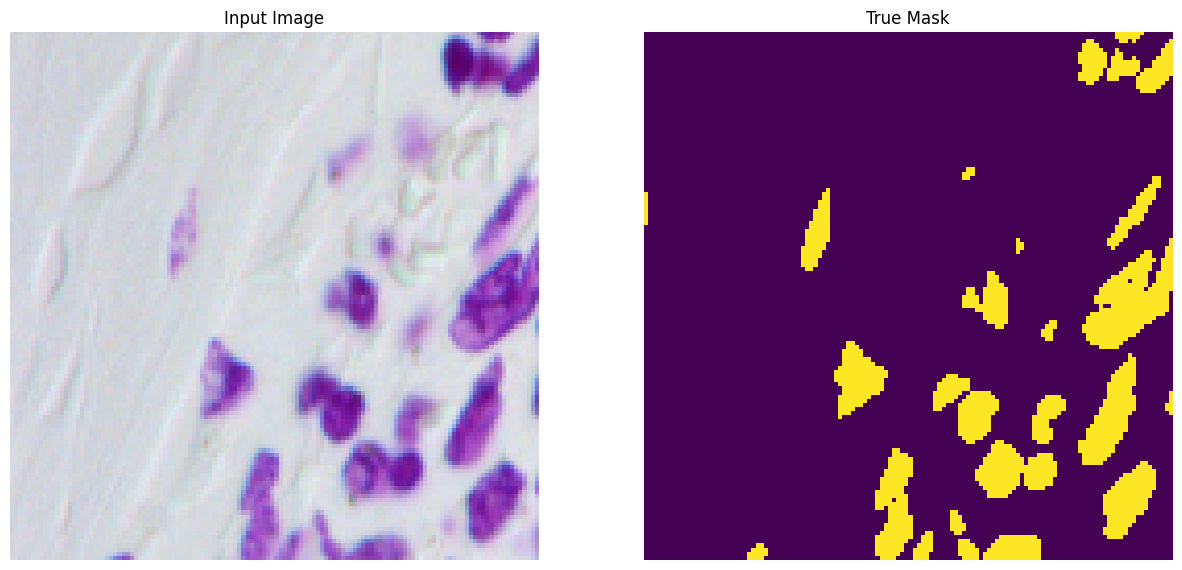

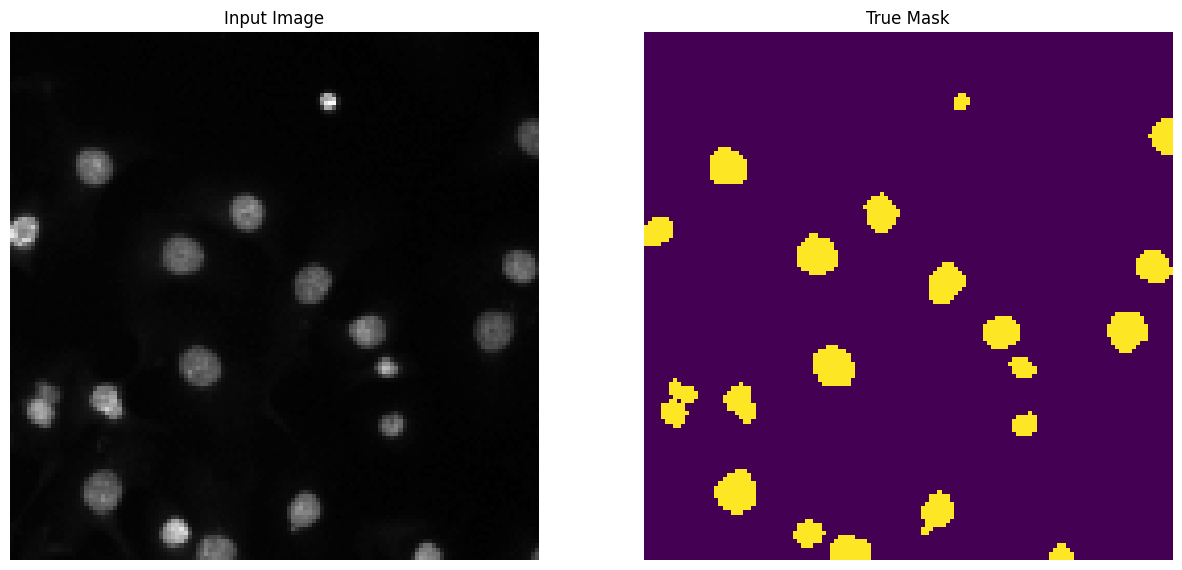

In [13]:
# visualise a sample of image and mask
for images, masks in test.take(1):
  for i in range(2):
    sample_image, sample_mask = images[i], masks[i]
    display([sample_image, sample_mask])

In [14]:
# Load the model
model = keras.models.load_model('/content/model.h5')

In [15]:
model.predict(test)

array([[[[ 2.0766582 , -1.2455626 ],
         [ 1.9239415 , -1.379756  ],
         [ 0.4077204 , -2.1491525 ],
         ...,
         [ 1.1684974 , -0.23944393],
         [ 0.47247523, -1.0008533 ],
         [ 1.2570643 , -0.7446692 ]],

        [[ 0.8416801 , -1.2020192 ],
         [ 1.1300396 , -1.3829466 ],
         [ 2.5984576 , -0.20695156],
         ...,
         [ 0.28867108, -0.47672457],
         [ 1.1192894 ,  0.65833414],
         [ 0.45982188, -0.4157844 ]],

        [[ 3.105047  , -0.6311754 ],
         [ 2.5228238 , -2.067688  ],
         [ 2.4343486 , -2.211275  ],
         ...,
         [ 0.4749142 , -0.07265199],
         [ 0.45714635,  0.7459035 ],
         [-0.5479677 , -0.7255126 ]],

        ...,

        [[ 1.3107438 , -0.223126  ],
         [ 2.3371549 , -1.4548997 ],
         [ 2.7078922 , -1.5649993 ],
         ...,
         [ 0.8788818 , -0.4561572 ],
         [ 0.54289466, -1.0419202 ],
         [ 0.23275384, -0.91089296]],

        [[ 2.3163955 ,  0.14670852

In [16]:
# see how good our model is
model.evaluate(test)

7/7 [==============================] - 9s 378ms/step - loss: 0.2115 - accuracy: 0.8919


[0.21148397028446198, 0.8919340968132019]

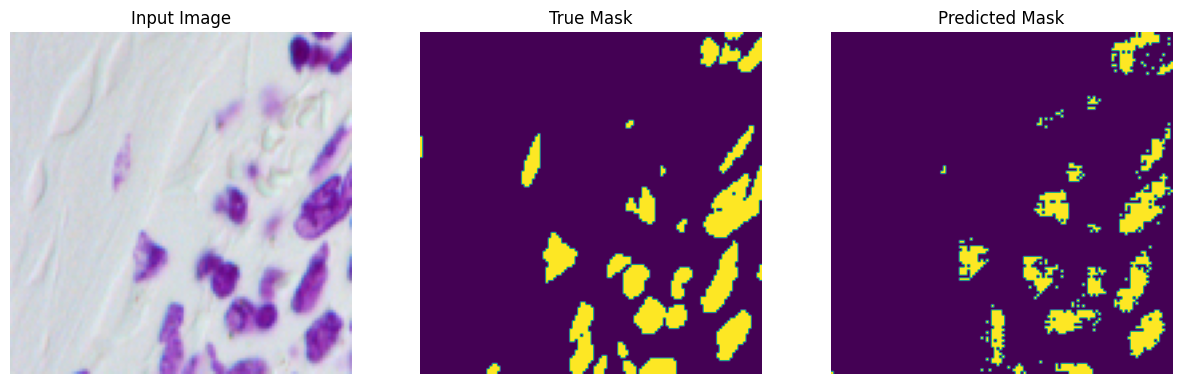

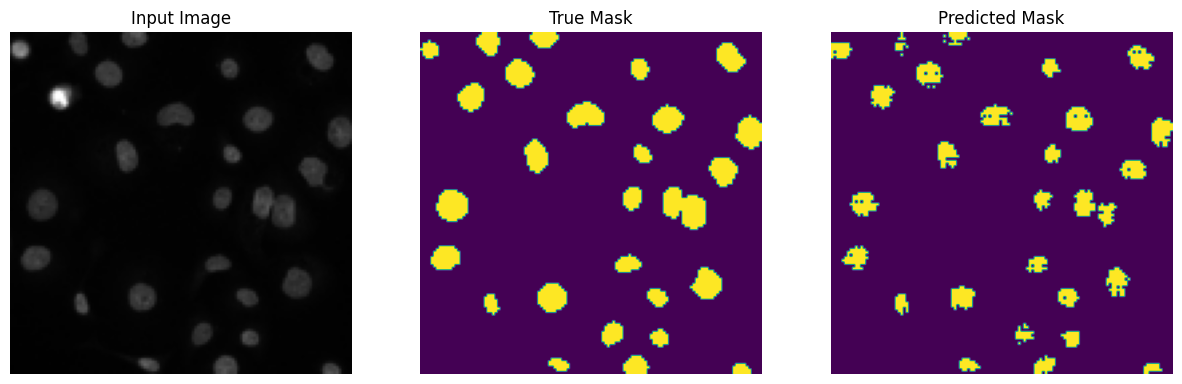

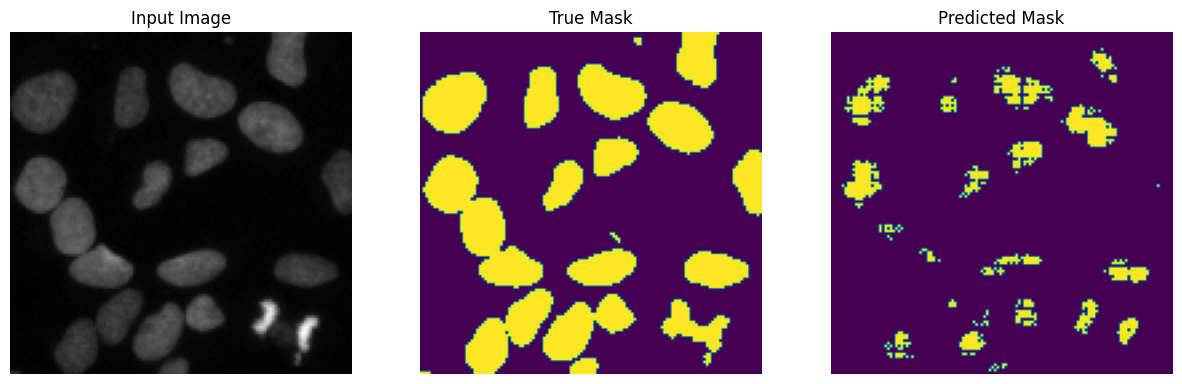

In [19]:
# display some predictions
show_predictions(test, 3)

Yeay! model ready for production :D.